### - Bibliotekos

In [145]:
import os
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd

### - Failo pasirinkimo dalis

In [175]:
folder = "ivairus"
files = [f for f in os.listdir(folder) if f.endswith(".wav")]

if not files:
    print(f"Kataloge \"{folder}\" nėra \".wav\" formato failų.")
    exit()

print("Pasirinkite failą iš pateiktų įvesdami skaičių:")
for i, f in enumerate(files, start=1):
    print(f"{i}. {f}")

while True:
    choice = int(input(f"Jūsų pasirinkimas (1–{len(files)}): "))
    if 1 <= choice <= len(files):
        file_path = os.path.join(folder, files[choice-1])
        print("Pasirinktas failas:", file_path)
        break
    else:
        print("Nėra tokio pasirinkimo.")


Pasirinkite failą iš pateiktų įvesdami skaičių:
1. Angry_german.wav
2. applause.wav
3. Brown_noise.wav
4. city_traffic.wav
5. DTMF_tones.wav
6. du_drambliai.wav
7. Elephant.wav
8. Englishman.wav
9. Female_scream.wav
10. muffled-drum-kick.wav
11. Multitone.wav
12. Neutral_lithuanian.wav
13. oceanwave.wav
14. Opera-vocal_129bpm_F_minor.wav
15. Sinus_125Hz.wav
16. Sinus_500Hz.wav
17. Stereo_music.wav
18. Thrash_metal.wav
19. White_noise.wav
20. woman-ohhahhh.wav


Jūsų pasirinkimas (1–20):  8


Pasirinktas failas: ivairus\Englishman.wav


### - Duomenų išsaugojimas atmintyje

In [177]:
signal, samplerate = sf.read(file_path, always_2d=True)
channels = signal.shape[1]
numpy_bit_depth = signal.dtype.itemsize * 8

# Kiekvienam kanalui priskiriamas atskiras laikas
channel_times = [np.arange(signal.shape[0]) / samplerate for _ in range(channels)]
channel_units = ["s"] * channels
subtype_to_bits = {
    "PCM_U8": 8,
    "PCM_16": 16,
    "PCM_24": 24,
    "PCM_32": 32,
    "FLOAT": 32,
    "DOUBLE": 64,
}
info = sf.info(file_path)
print(info)
bit_depth = subtype_to_bits.get(info.subtype, None)

ivairus\Englishman.wav
samplerate: 44100 Hz
channels: 1
duration: 3.252 s
format: WAV (Microsoft) [WAV]
subtype: Signed 16 bit PCM [PCM_16]


### - Grafikų braižymas kiekvienam kanalui

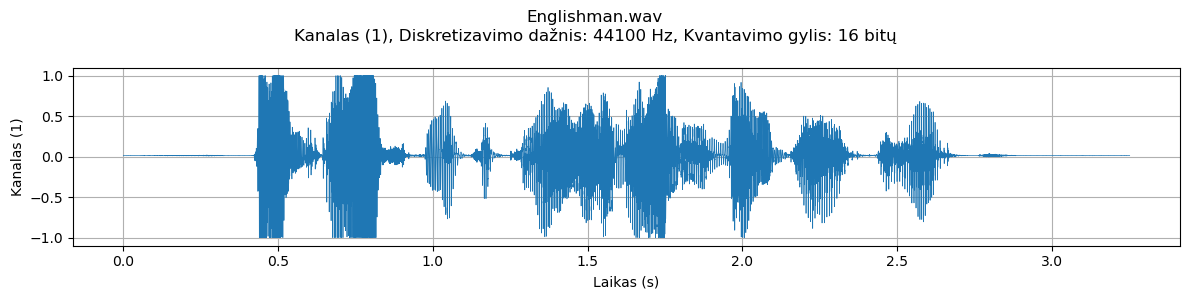

In [179]:
for ch in range(channels):
    time = channel_times[ch]
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.plot(time, signal[:, ch], lw=0.5)
    ax.set_ylabel(f"Kanalas ({ch+1})")
    ax.set_xlabel("Laikas (s)")
    ax.grid(True)
    fig.suptitle(f"{os.path.basename(file_path)}\nKanalas ({ch+1}), "
                 f"Diskretizavimo dažnis: {samplerate} Hz, "
                 f"Kvantavimo gylis: {bit_depth} bitų")
    plt.tight_layout()
    plt.show()

### - Galimybė perklausyti garso įrašą

In [321]:
print("Ar norite perklausyti pradinį įrašą?")
selector = int(input(f"Įveskite 1 (taip) arba 0 (ne): "))
if(selector == 1):
    sd.play(signal, samplerate)
    print("\nGrojimas..")
    sd.wait() 
    print("Pabaiga")
else:
    print("Pasirinkote nepaleisti garso įrašo")

Ar norite perklausyti pradinį įrašą?


Įveskite 1 (taip) arba 0 (ne):  1



Grojimas..
Pabaiga


### - Pseudo stereo efekto pritaikymas įrašui

Įveskite vėlinimo trukmę (ms, pvz.: 2):  8


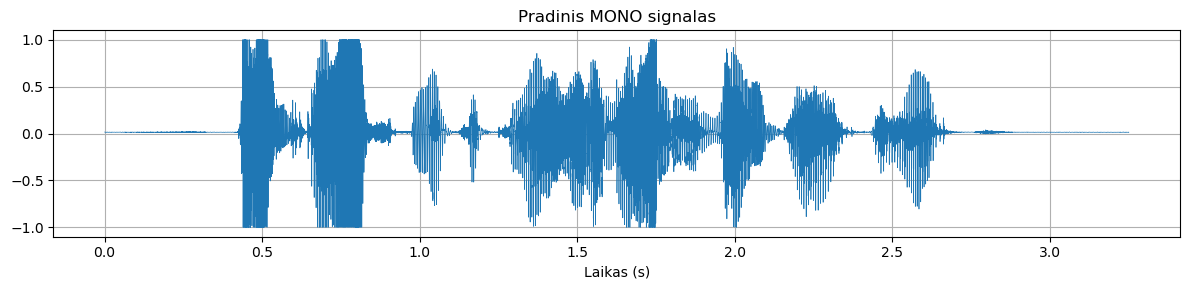

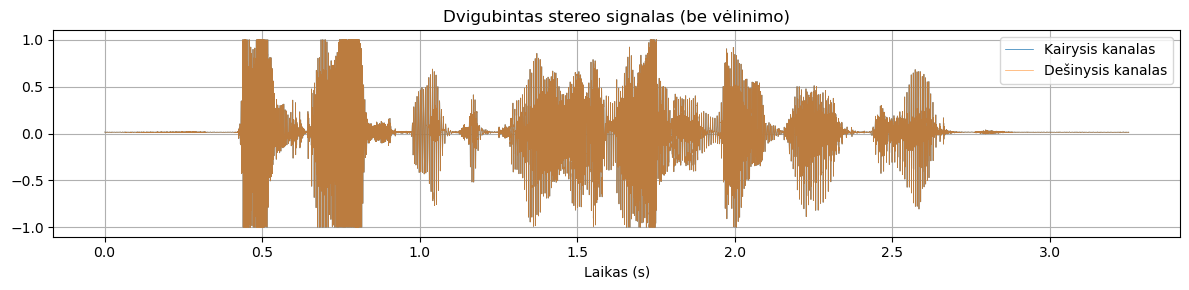

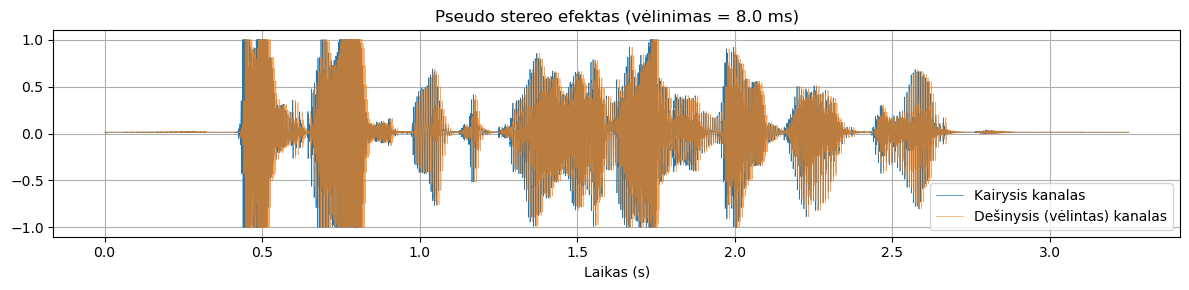

In [361]:
# Jei kanalas mono - mes jį duplikuojame
if signal.shape[1] == 1:
    signal_stereo = np.repeat(signal, 2, axis=1)
else:
    signal_stereo = signal.copy()

# Nuskaitome vėlinimo trukmę ir paverčiam ją iš s į ms.
delay_ms = float(input("Įveskite vėlinimo trukmę (ms, pvz.: 2): "))
delay_samples = int((delay_ms / 1000) * samplerate)

# Sukuriame stereo įrašo kopiją efekto taikymui
pseudo_stereo = signal_stereo.copy()
if delay_samples > 0:
    delayed = np.zeros_like(signal_stereo)
    # paliekam pirmąjį kanalą nekeistą
    delayed[:, 0] = signal_stereo[:, 0]
    # pavėliname antrajį kanalą
    delayed[delay_samples:, 1] = signal_stereo[:-delay_samples, 1]
    pseudo_stereo = delayed

# Kiekvienam kanalui priskiriamas atskiras laikas
channels = pseudo_stereo.shape[1]
channel_times = [np.arange(signal_stereo.shape[0]) / samplerate for _ in range(channels)]

time = channel_times[0]

# Pradinio mono įrašo vizualizacija
if signal.shape[1] == 1:
    plt.figure(figsize=(12, 3))
    plt.plot(time, signal[:, 0], lw=0.5)
    plt.title("Pradinis MONO signalas")
    plt.xlabel("Laikas (s)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Duplikuoto stereo įrašo (be vėlinimo) vizualizacija
plt.figure(figsize=(12, 3))
plt.plot(time, signal_stereo[:, 0], lw=0.5, label="Kairysis kanalas")
plt.plot(time, signal_stereo[:, 1], lw=0.5, label="Dešinysis kanalas", alpha=0.7)
plt.title("Dvigubintas stereo signalas (be vėlinimo)")
plt.xlabel("Laikas (s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Pseudo stereo įrašo (su vieno kanalo pavėlinimu) vizualizacija
plt.figure(figsize=(12, 3))
plt.plot(time, pseudo_stereo[:, 0], lw=0.5, label="Kairysis kanalas")
plt.plot(time, pseudo_stereo[:, 1], lw=0.5, label="Dešinysis (vėlintas) kanalas", alpha=0.7)
plt.title(f"Pseudo stereo efektas (vėlinimas = {delay_ms:.1f} ms)")
plt.xlabel("Laikas (s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### - Galimybė perklausyti Pseudo stereo įrašą

In [363]:
print("Ar norite perklausyti galutinį įrašą?")
selector = int(input(f"Įveskite 1 (taip) arba 0 (ne): "))
if(selector == 1):
    sd.play(pseudo_stereo, samplerate)
    print(f"Grojamas pseudo-stereo efektas su {delay_ms:.1f} ms vėlinimu...")
    sd.wait() 
    print("Pabaiga")
else:
    print("Pasirinkote nepaleisti garso įrašo")

Ar norite perklausyti galutinį įrašą?


Įveskite 1 (taip) arba 0 (ne):  1


Grojamas pseudo-stereo efektas su 8.0 ms vėlinimu...
Pabaiga


### - Modifikuoto įrašo išsaugojimas

In [349]:
save_choice = int(input("Ar norite išsaugoti apdorotą signalą? Įveskite 1 (taip) arba 0 (ne): "))
if save_choice == 1:
    save_name = input("Įveskite naujo failo pavadinimą (be .wav): ").strip()
    save_path = os.path.join(folder, f"{save_name}.wav")
    sf.write(save_path, pseudo_stereo, samplerate)
    print(f"Failas išsaugotas: {save_path}")
else:
    print("Failas neišsaugotas.")

Ar norite išsaugoti apdorotą signalą? Įveskite 1 (taip) arba 0 (ne):  1
Įveskite naujo failo pavadinimą (be .wav):  Englishman_20ms


Failas išsaugotas: ivairus\Englishman_20ms.wav
